# Forecasting and Managing Market Volatility: ARIMA + GARCH to Adjust Position Size


## Dont forget to !pip install statsmodels yfinance arch matplotlib scipy

### 1) Downloading Data, Computing Log Return and Splitting the Dataset

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
ticker = "AAPL"
start_time = "2015-01-01"
end_time = "2025-01-01"
# Download OHLCV(Open, High, Low, Close, Volume and Adjusted Close)
data = yf.download(ticker, start=start_time, end=end_time, auto_adjust=False,progress=False)
#Reindex to business days and forward fill missing values
data = data.asfreq("B").ffill()
# Computing Daily Log Return from Adjusted Close
returns = np.log(data["Adj Close"]).diff().dropna()
#Splitting the Dataset to Train dataset and Test dataset.
test_start = pd.Timestamp("2022-01-01")
daily_returns_train = returns[returns.index < test_start].dropna()
daily_returns_test  = returns[returns.index >= test_start].dropna()


print(daily_returns_train.index.min(), "->", daily_returns_train.index.max(), "Training Window")
print(daily_returns_test.index.min(),  "->", daily_returns_test.index.max(),  "Test Window")


2015-01-05 00:00:00 -> 2021-12-31 00:00:00 Training Window
2022-01-03 00:00:00 -> 2024-12-31 00:00:00 Test Window


### 2) Exploratory Checks

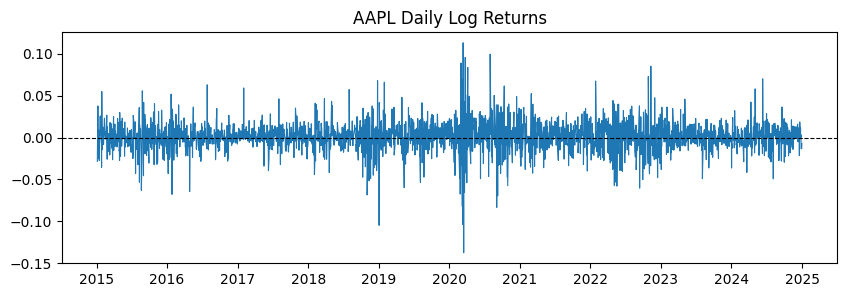

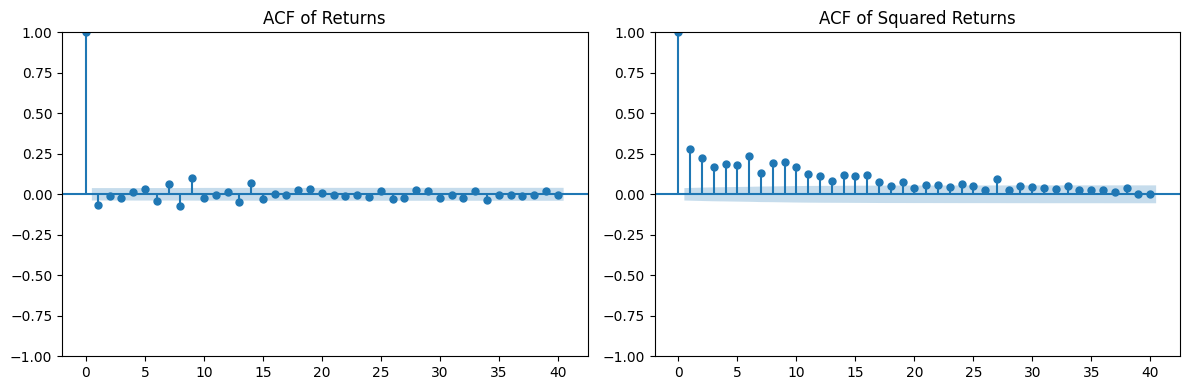

In [2]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting Daily Log Returns of AAPL to show that its stationarity 
plt.figure(figsize=(10,3))
plt.plot(returns.index, returns.values, linewidth=0.8)
plt.title("AAPL Daily Log Returns")
plt.axhline(0, color="k", linestyle="--", linewidth=0.8)
plt.show()

# Plotting ACF for returns and squared returns to check for volatility clusters
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(returns, lags = 40, ax=ax[0])
ax[0].set_title("ACF of Returns")
plot_acf(returns**2, lags=40,ax=ax[1])
ax[1].set_title("ACF of Squared Returns")
plt.tight_layout()
plt.show()

## ARIMA order selection (p,d,q)
### 3) Inspecting ACF and PACF to suggest p and q


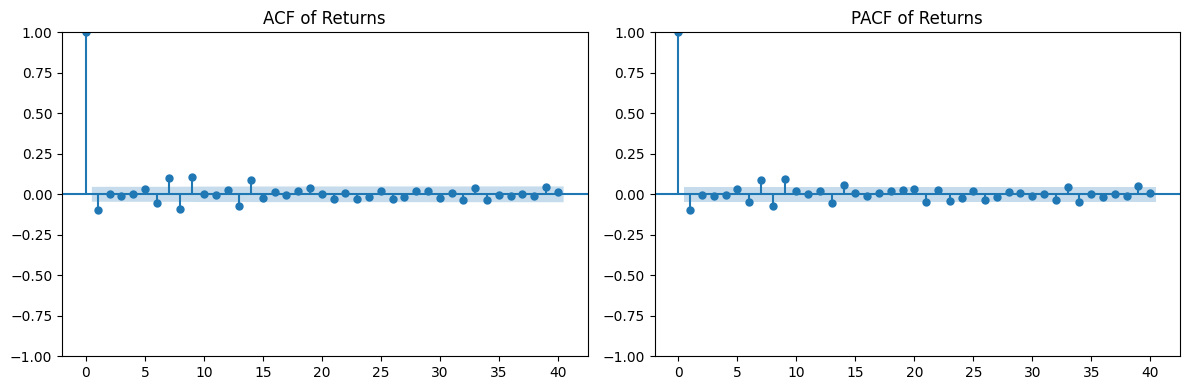

In [3]:
# ACF helps for MA(k) and PACF helps for AR(k)
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(daily_returns_train, lags = 40, ax=ax[0])
ax[0].set_title("ACF of Returns")
plot_pacf(daily_returns_train, lags=40,ax=ax[1])
ax[1].set_title("PACF of Returns")
plt.tight_layout()
plt.show()

### 4) Fit ARIMA on training data only, get residuals

In [10]:
import itertools
from statsmodels.tsa.arima.model import ARIMA

best_aic = np.inf 
best_order = None 
for p, d, q in itertools.product(range(3), [0], range(3)): 
    try: 
        fit_tmp = ARIMA(daily_returns_train, order=(p, d, q)).fit() 
        if fit_tmp.aic < best_aic: best_aic, best_order = fit_tmp.aic, (p, d, q) 
    except Exception: 
        pass 
print("Chosen ARIMA order from training data:", best_order) 
arima_fit_train = ARIMA(daily_returns_train, order=(1,0,1)).fit() # (1,0,1) gives a better sharpe
arima_residuals_train = arima_fit_train.resid.dropna()

C:\Users\erayb\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erayb\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\erayb\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\erayb\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization f

Chosen ARIMA order from training data: (1, 0, 2)


### 5) Residual diagnostics

In [11]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
# Ljung-Box test for autocorrelation in residuals, normally p-values should be bigger than 0.05 
acorr = acorr_ljungbox(arima_residuals_train, lags=[10, 20], return_df=True) 
print("Ljung-Box test:") 
print(acorr, "\n") 

# ARCH-LM test for volatility clustering, small p-value means ARCH effect 
arch_lm = het_arch(arima_residuals_train, nlags=10) 
print("ARCH-LM test:") 
print(f"LM Stat: {arch_lm[0]:.4f}, p-value: {arch_lm[1]:.4f}")


Ljung-Box test:
      lb_stat     lb_pvalue
10  46.599972  1.116346e-06
20  70.620902  1.441731e-07 

ARCH-LM test:
LM Stat: 295.1970, p-value: 0.0000


### 6) Fit GARCH on ARIMA residuals 

In [12]:
from arch import arch_model
garch_model_train = arch_model(arima_residuals_train * 100, vol="GARCH", p=1, q=1, dist="t")
garch_fit_train   = garch_model_train.fit(disp="off")
print(garch_fit_train.summary())


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -3341.20
Distribution:      Standardized Student's t   AIC:                           6692.40
Method:                  Maximum Likelihood   BIC:                           6719.95
                                              No. Observations:                 1825
Date:                      Thu, Oct 16 2025   Df Residuals:                     1824
Time:                              10:15:21   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

### 7) Forecast one day ahead across the Test Window

In [13]:
arima_extended = arima_fit_train.append(daily_returns_test, refit=False)
mu_test = arima_extended.predict(start=daily_returns_test.index[0], end=daily_returns_test.index[-1])

# Residuals on the test window are actual minus ARIMA mean forecast
residuals_test = daily_returns_test["AAPL"] - mu_test
residuals_test = residuals_test.dropna()
residuals_so_far = arima_residuals_train.copy()
forecasts = []

for t, eps_t in residuals_test.items():
    # Fit GARCH(1,1) on residuals_so_far in percent units
    garch_model = arch_model(residuals_so_far * 100, vol="GARCH", p=1, q=1, dist="t")
    garch_fit   = garch_model.fit(disp="off")
    # One step ahead forecast of variance in percent^2
    fcast = garch_fit.forecast(horizon=1, reindex=False)
    var_next_pct2 = float(fcast.variance.values[-1, 0])  # percent^2
    # Convert to return units: divide by 100^2 then sqrt for sigma
    sigma_next = np.sqrt(var_next_pct2) / 100.0
    forecasts.append((t, sigma_next))
    # Append the realized next residual to the expanding window
    residuals_so_far = pd.concat([residuals_so_far, pd.Series([eps_t], index=[t])])

forecasted_daily_volatility = pd.Series(
    data=[v for _, v in forecasts],
    index=[t for t, _ in forecasts]
).reindex(daily_returns_test.index).ffill()  # align and fill any initial gap

# Align test returns to volatility index
aligned_test_returns = daily_returns_test.loc[forecasted_daily_volatility.index]

### 8) Volatility Targeting on Test Data

In [14]:
# This code will apply a adaptive leverage rule that keeps the strategy’s volatility stable over time.
# Defining the risk target
trading_days_per_year = 252
target_annual_volatility = 0.10 # 10% annualized volatility - std of returns per year should be 10%

# Converting annual volatility to daily volatility
target_daily_volatility = target_annual_volatility / np.sqrt(trading_days_per_year) # roughly 0.63% per day

# Preventing absurdly high leverage by setting a leverage cap 
leverage_cap = 10.0

# Computing scaling factor (the leverage)
scaling_factor = (target_daily_volatility / forecasted_daily_volatility.replace(0.0, np.nan)) \
                    .clip(upper=leverage_cap) \
                    .fillna(0.0)
# Defining the baseline and volatility-targeted version
strategy_returns_fixed_exposure = aligned_test_returns.copy()
strategy_returns_volatility_targeted = scaling_factor * aligned_test_returns["AAPL"]


### 9) Performance Evaluation and Plots on Test Data

Sharpe, fixed exposure:       0.437
Sharpe, volatility targeted:  0.565
Max drawdown, fixed exposure: -35.18%
Max drawdown, vol targeted:   -11.46%


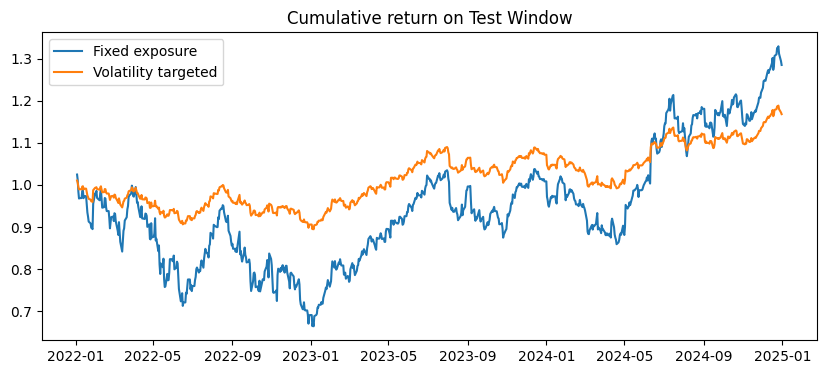

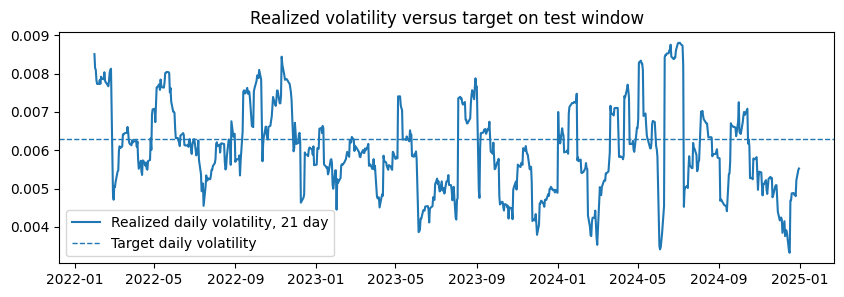

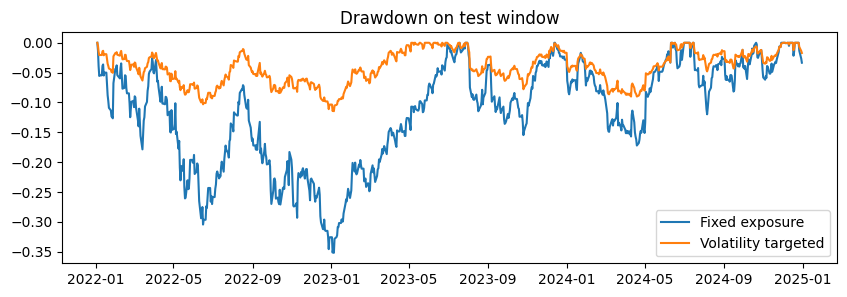

In [15]:
def annualized_sharpe_ratio(return_series, days_per_year=252):
    cleaned = return_series.dropna()
    sd = cleaned.std(ddof=1)
    return cleaned.mean() / sd * np.sqrt(days_per_year)
    
def cumulative_return_series(return_series):
    cleaned = return_series.fillna(0.0)
    # Adding 1 to simulate the growth factor, if we plot this function it will be the equity curve
    return (1.0 + cleaned).cumprod()
def drawdown_series(return_series):
    equity_curve = cumulative_return_series(return_series)
    running_peak = equity_curve.cummax()
    return (equity_curve - running_peak) / running_peak
def maximum_drawdown(return_series):
    return drawdown_series(return_series).min()
# Computing Sharpe Ratio on fixed exposure and volatility-targeted version
sharpe_fixed = annualized_sharpe_ratio(strategy_returns_fixed_exposure.squeeze())
sharpe_target = annualized_sharpe_ratio(strategy_returns_volatility_targeted.squeeze())
# Computing Maximum Drawdown on fixed exposure and volatility-targeted version
max_dd_fixed = maximum_drawdown(strategy_returns_fixed_exposure.squeeze())
max_dd_target = maximum_drawdown(strategy_returns_volatility_targeted.squeeze())

print(f"Sharpe, fixed exposure:       {sharpe_fixed:.3f}")
print(f"Sharpe, volatility targeted:  {sharpe_target:.3f}")
print(f"Max drawdown, fixed exposure: {max_dd_fixed:.2%}")
print(f"Max drawdown, vol targeted:   {max_dd_target:.2%}")

# Acquiring Equitiy Curve for fixed exposure and volatility-targeted version
cumulative_fixed  = cumulative_return_series(strategy_returns_fixed_exposure)
cumulative_target = cumulative_return_series(strategy_returns_volatility_targeted)

# Plotting the equity curves
plt.figure(figsize=(10,4))
plt.plot(cumulative_fixed.index,  cumulative_fixed.values,  label="Fixed exposure")
plt.plot(cumulative_target.index, cumulative_target.values, label="Volatility targeted")
plt.title("Cumulative return on Test Window")
plt.legend()
plt.show()

# Plotting realized volatility versus target, realized volatility should oscilate around target daily volatility
realized_daily_volatility = strategy_returns_volatility_targeted.rolling(21).std(ddof=1)
plt.figure(figsize=(10,3))
plt.plot(realized_daily_volatility.index, realized_daily_volatility.values, label="Realized daily volatility, 21 day")
plt.axhline(target_daily_volatility, linestyle="--", linewidth=1, label="Target daily volatility")
plt.title("Realized volatility versus target on test window")
plt.legend()
plt.show()

# Acquiring Drawdown curves
drawdown_fixed  = drawdown_series(strategy_returns_fixed_exposure)
drawdown_target = drawdown_series(strategy_returns_volatility_targeted)

# Plotting the Drawdown curves of fixed exposure and volatility-targeted version
plt.figure(figsize=(10,3))
plt.plot(drawdown_fixed.index,  drawdown_fixed.values,  label="Fixed exposure")
plt.plot(drawdown_target.index, drawdown_target.values, label="Volatility targeted")
plt.title("Drawdown on test window")
plt.legend()
plt.show()


### Eray Bahar

---

 **Find me online:** [LinkedIn](https://www.linkedin.com/in/eraybahar/) • [GitHub](https://github.com/ErayBahar) • [Medium](https://medium.com/@eraybahar24)

---
